# **===========================================================================================================================================================** #
# **Incremental Capstone 4** #
# **===========================================================================================================================================================** #

In [386]:
# Import Libraries
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import t
from scipy.stats import boxcox, yeojohnson, shapiro
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_absolute_error
import platform
import sys

# How to tell python version
#print (sys.version_info)
#print (platform.python_version())

# How to pip install from Terminal window:
# python -m pip install seaborn

# Put this at the top of your notebook
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)  # Set a large number
pd.set_option('display.max_colwidth', None)

# Set random seed for reproducibility
np.random.seed(315)


# 1. Analyze the Data #

In [376]:
# Import data into DataFrame
# Renamed CSV file is assumed to live in same folder as my notebook
df_NSME1988_dirty = pd.read_csv("NSMES1988_Dirty.csv")

# Make a copy of the dataframe to contain the modifications completed in this workbook
df_NSME1988_dirty_new = df_NSME1988_dirty.copy(deep=True)

# Let's look at what we just imported and get some more info
# I like to delineate output to make it more readable

# Print Stats
print("***********************************")
print("Description Stats")
print("***********************************")
print()
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)
print(df_NSME1988_dirty.describe(include='all').T)
print()

# Print df Column Info
print("***********************************")
print("Basic Info of imported data set")
print("***********************************")
print()
df_NSME1988_dirty.info()
print()
print()


print(f'df_NSME1988_dirty Shape:{df_NSME1988_dirty.shape}')
print()

print('Do we have any missing values:')
print(df_NSME1988_dirty.isnull().any().any())
print()

print('Feature Columns with that have missing values:')
print(df_NSME1988_dirty.isnull().sum()[df_NSME1988_dirty.isnull().sum() > 0])
print()

print("***********************************")
print("First 20 rows of Data")
print("***********************************")
print()
print(df_NSME1988_dirty.head(20))
print()

print("***********************************")
print("First 20 rows of Random Sample Data")
print("***********************************")
print()
print(df_NSME1988_dirty.sample(20))
print

***********************************
Description Stats
***********************************

            count unique      top  freq       mean       std       min       25%       50%       75%        max
visits     4186.0    NaN      NaN   NaN   6.006928  7.361932      -2.0       1.0       4.0       8.0       94.0
nvisits    4186.0    NaN      NaN   NaN   1.615862  5.308146      -1.0       0.0       0.0       1.0      103.0
ovisits    4186.0    NaN      NaN   NaN   0.728141  3.594853      -1.0       0.0       0.0       0.0      139.0
novisits   4186.0    NaN      NaN   NaN   0.550406  4.120928      -1.0       0.0       0.0       0.0      162.0
emergency  4186.0    NaN      NaN   NaN   0.262303  0.694748       0.0       0.0       0.0       0.0       12.0
hospital   4186.0    NaN      NaN   NaN   0.299092  0.755314       0.0       0.0       0.0       0.0        8.0
health       4406      3  average  3483        NaN       NaN       NaN       NaN       NaN       NaN        NaN
chronic    41

<function print(*args, sep=' ', end='\n', file=None, flush=False)>

#### Potential Data Issues from Imported Data ####
    1. The following columns (features) have missing data:
        visits      
        nvisits     
        ovisits     
        novisits    
        emergency   
        hospital    
        chronic     
        age         
        school      
        income       
        insurance

    2. Data Types 
        The following data types should be converted to integers - for performance purposes
            visits     4186 non-null   float64
            nvisits    4186 non-null   float64
            ovisits    4186 non-null   float64
            novisits   4186 non-null   float64
            emergency  4186 non-null   float64
            hospital   4186 non-null   float64
            chronic    4186 non-null   float64
            age        4186 non-null   float64
            school     4186 non-null   float64
            income     4186 non-null   float64
        The additional data type conversions/fixups should probably be done:
        These conversions should be done before/while we convert from float to int
            age -> needs to be normalized to it's absolulte/actual value - suspicious 7.67 probably multiply by 10
            income -> same as age
        These columns should be made into categorical variables:
            chronic -> category (object) -> ordinal value
        These columns should be converted from yes/no to bool (True/False) and/or (1/0)
            employed
            insured
            married
            medicaid
        


### Plot the original "Dirty Data" to see distributions ###
#### Feature Distributions for Numerical Columns-- Histograms ####

Numeric Feature Columns to plot
['visits', 'nvisits', 'ovisits', 'novisits', 'emergency', 'hospital', 'chronic', 'age', 'school', 'income']
Number of Columns: 10


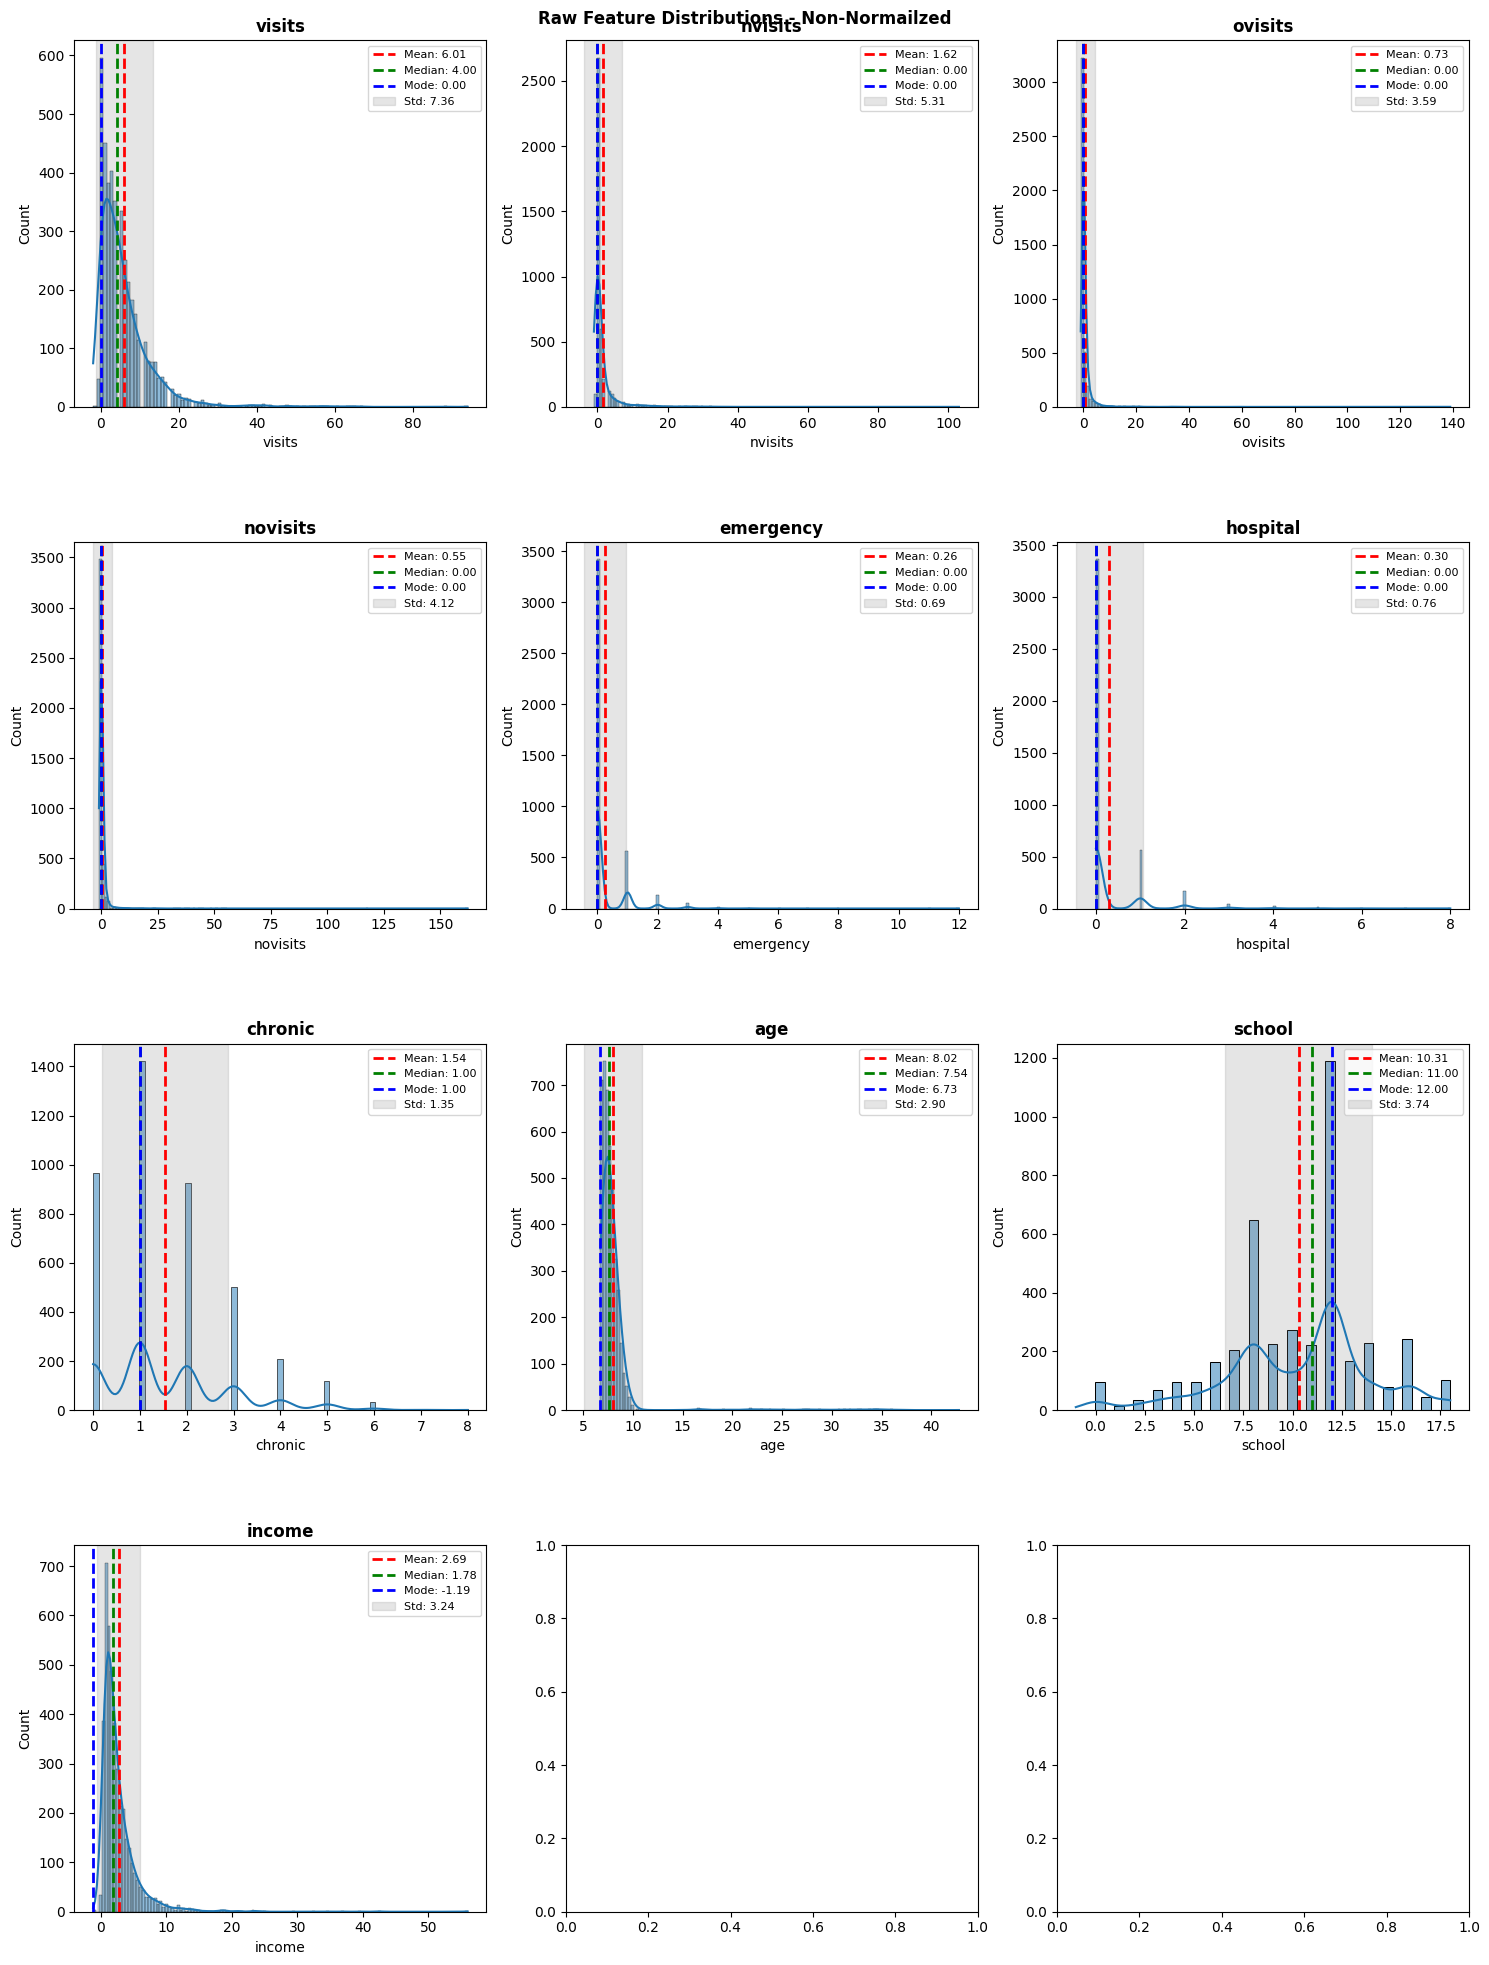

In [377]:
# The columns we want to plot:
print('Numeric Feature Columns to plot')
numeric_cols = df_NSME1988_dirty.select_dtypes(include=['number']).columns.tolist()
print(numeric_cols)

n_cols = len(numeric_cols)
print(f'Number of Columns: {n_cols}')

fig, axes = plt.subplots(nrows=(n_cols + 2) // 3, ncols=3, figsize=(15, 5 * ((n_cols + 2) // 3)))
axes = axes.flatten()

plt.suptitle('Raw Feature Distributions - Non-Normailzed', fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.90])  # Leave space at top

#Iterate over each numeric column and plot a historgram
for i, col in enumerate(numeric_cols):
    sns.histplot(data=df_NSME1988_dirty, x=col, ax=axes[i], kde=True)    
    axes[i].set_title(col, fontweight='bold')

    # Calculate statistics
    mean_val = df_NSME1988_dirty[col].mean()
    median_val = df_NSME1988_dirty[col].median()
    mode_val = df_NSME1988_dirty[col].mode()[0] if not df_NSME1988_dirty[col].mode().empty else None
    std_val = df_NSME1988_dirty[col].std()

    # Plot Statistics as Vertical Lines
    axes[i].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    axes[i].axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')
    if mode_val is not None:
        axes[i].axvline(mode_val, color='blue', linestyle='--', linewidth=2, label=f'Mode: {mode_val:.2f}')
    
    # Add std as shaded region around mean
    axes[i].axvspan(mean_val - std_val, mean_val + std_val, alpha=0.2, color='gray', label=f'Std: {std_val:.2f}')
    
    # Add legend
    axes[i].legend(fontsize=8, loc='upper right')


# Make plots more readable and add space
plt.tight_layout(h_pad=5)
plt.show()   

##### Histogram Analysis #####
    1. The following columns' distribution is right skewed (indicating the presence of outliers).
        This will have to be fixed via cropping as we seek a more normalized distribution.
        visits      
        nvisits     
        ovisits     
        novisits    
        emergency   
        hospital    
        chronic     
        age         
        school      
        income       
        insurance
    2. Age does not follow this pattern. It looks like a more normal or bimodal distribution.


#### Box Plots for Numerical Columns-- Identify Outliers ####

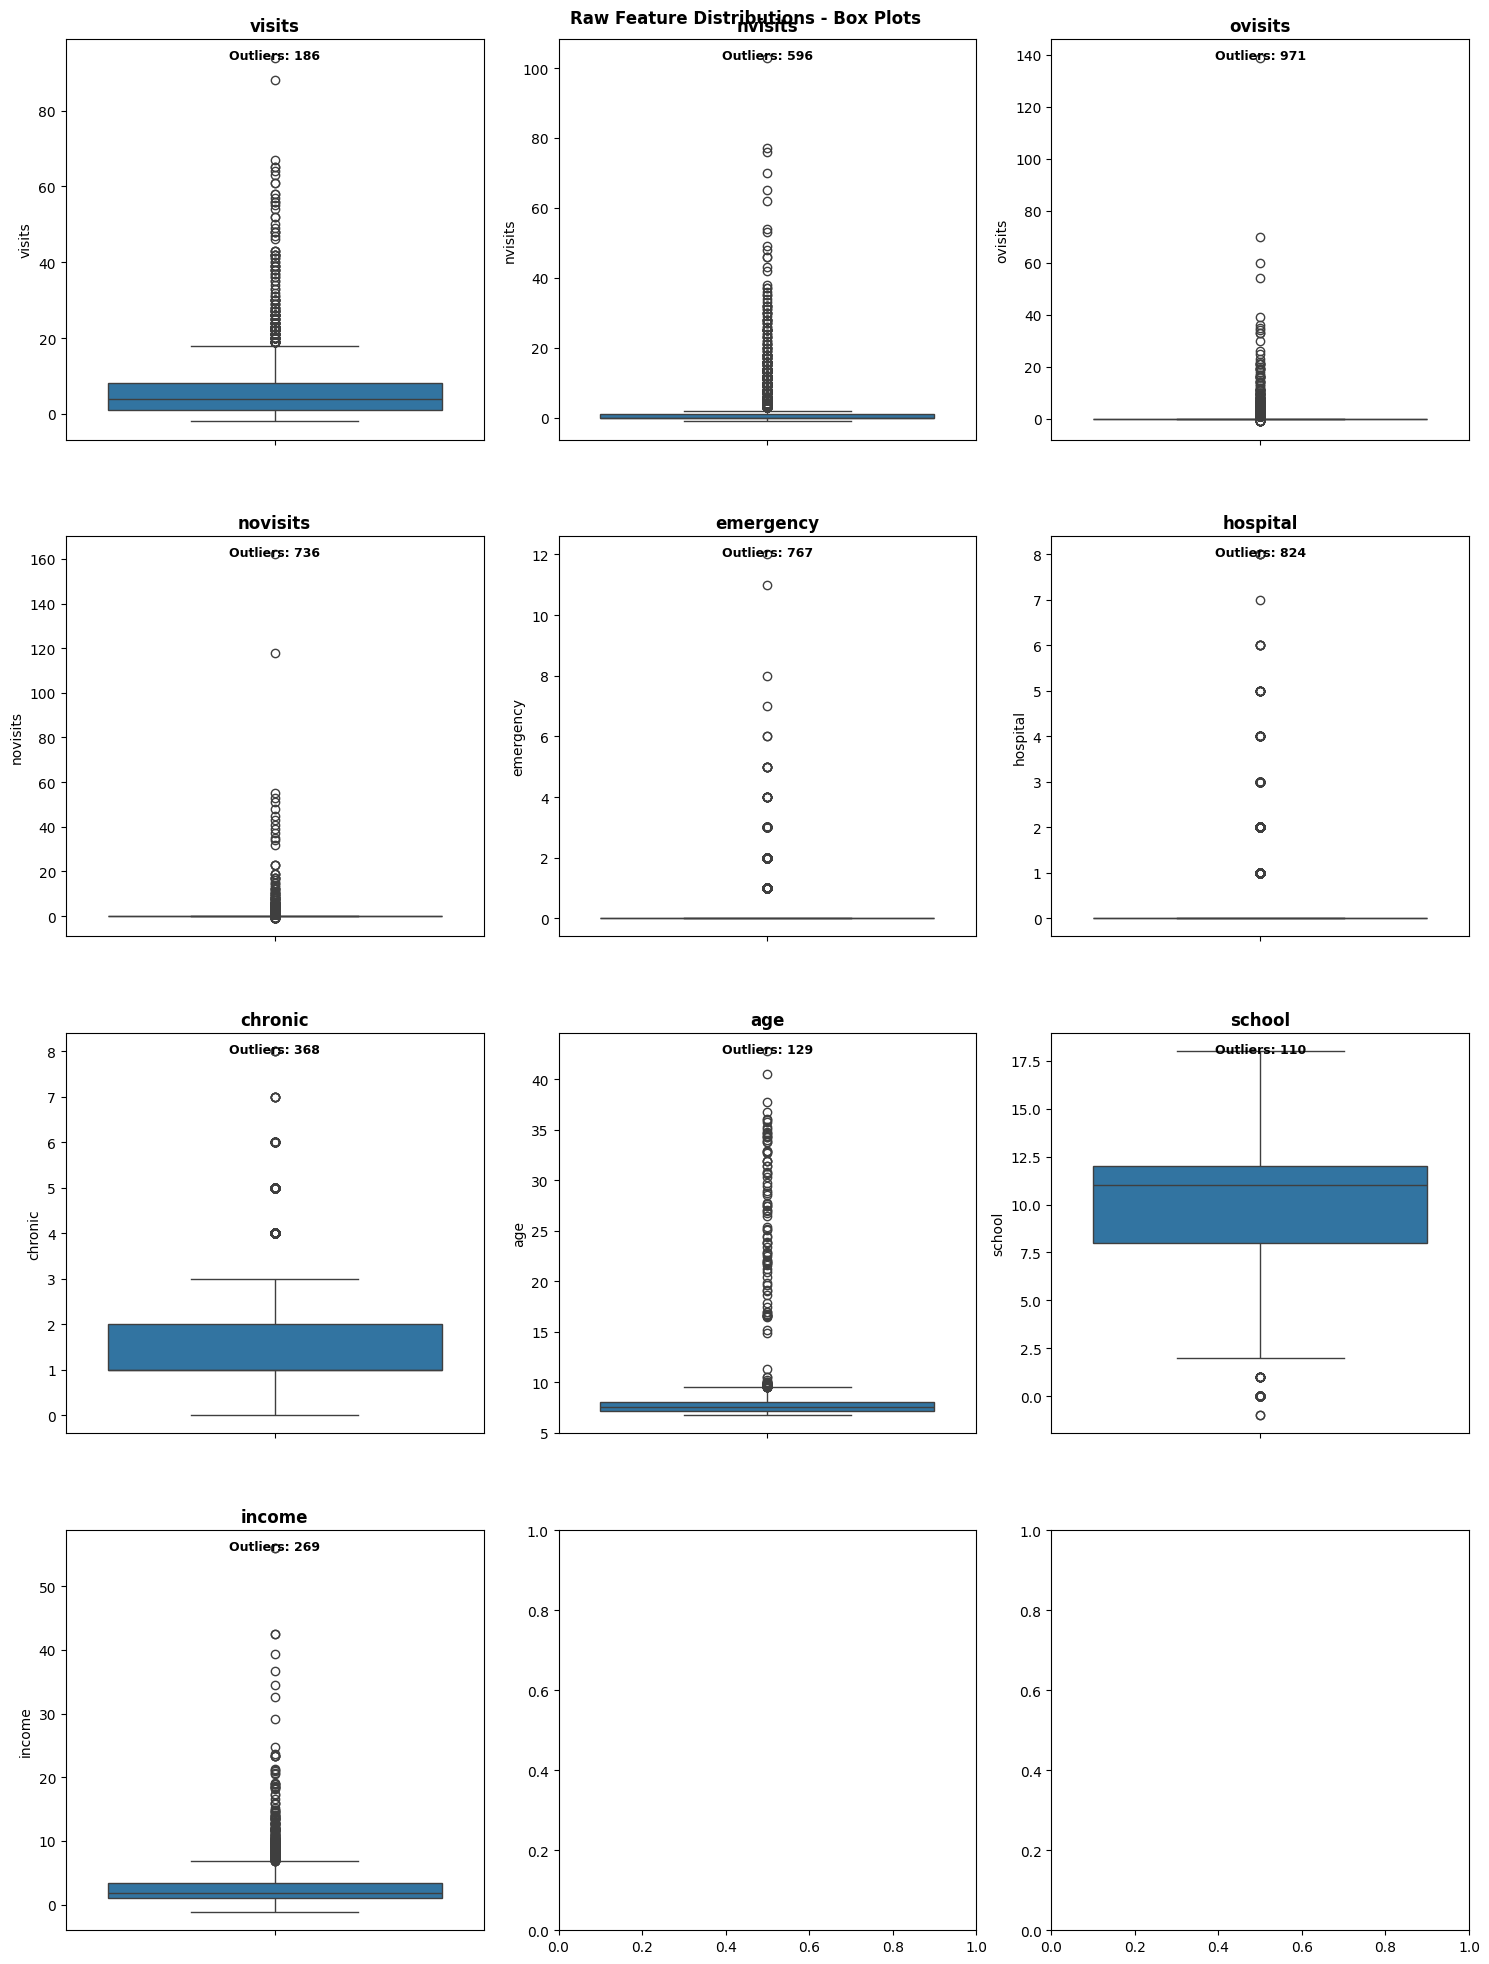

In [378]:

fig, axes = plt.subplots(nrows=(n_cols + 2) // 3, ncols=3, figsize=(15, 5 * ((n_cols + 2) // 3)))
axes = axes.flatten()

plt.suptitle('Raw Feature Distributions - Box Plots', fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.90])  # Leave space at top

#Iterate over each numeric column and plot a historgram
for i, col in enumerate(numeric_cols):
    sns.boxplot(data=df_NSME1988_dirty, y=col, ax=axes[i])    
    axes[i].set_title(col, fontweight='bold')

    # Optional: Add count of outliers
    Q1 = df_NSME1988_dirty[col].quantile(0.25)
    Q3 = df_NSME1988_dirty[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outlier_count = len(df_NSME1988_dirty[(df_NSME1988_dirty[col] < lower) | 
                                           (df_NSME1988_dirty[col] > upper)])
    axes[i].text(0.5, 0.95, f'Outliers: {outlier_count}', 
                 transform=axes[i].transAxes, ha='center', fontsize=9, fontweight='bold')

# Make plots more readable and add space
plt.tight_layout(h_pad=5)
plt.show()   

##### BoxPlot Analysis #####
    1. The boxplots reinforce the histograms results, indicating outliers in the higher values (which relate to right skewedness).
    The outliers indicate a high volume of outliers (lots of circles above the box).
    The boxes for most of them look pretty small which indicates the median is close to zero (0).
    It looks like healthcare resources aren't heavily used.
        visits      
        nvisits     
        ovisits     
        novisits    
        emergency   
        hospital    
        chronic     
        age         
        school      
        income       
        insurance
    2. School looks like it's got some outliers at the lower values, which would point to a left skew with some lower valued outliers.
       I don't think we want to fix (crop) this because lower education could very well be a predicator and have some significance.


     visits  nvisits  ovisits  novisits  emergency  hospital  chronic        age  school     income
min    -2.0     -1.0     -1.0      -1.0        0.0       0.0      0.0   6.727041    -1.0  -1.188950
25%     1.0      0.0      0.0       0.0        0.0       0.0      1.0   7.120889     8.0   0.949594
50%     4.0      0.0      0.0       0.0        0.0       0.0      1.0   7.538431    11.0   1.780207
75%     8.0      1.0      0.0       0.0        0.0       0.0      2.0   8.073698    12.0   3.309630
max    94.0    103.0    139.0     162.0       12.0       8.0      8.0  42.769033    18.0  55.984310


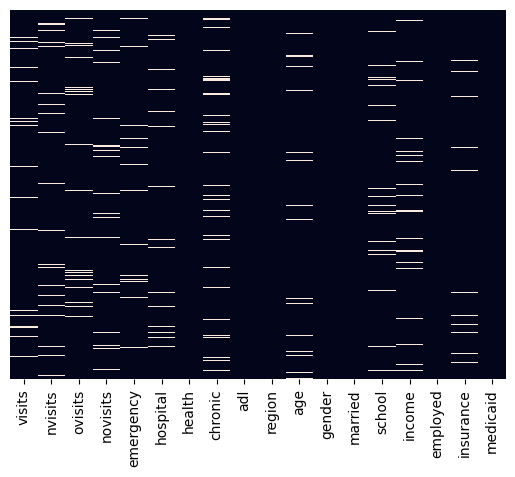

In [379]:
# Examine value ranges for numeric columns
#

summary = pd.DataFrame()

for i, col in enumerate(numeric_cols):
    summary = df_NSME1988_dirty[numeric_cols].describe().loc[['min', '25%', '50%', '75%', 'max']]
    
print(summary)

sns.heatmap(df_NSME1988_dirty.isnull(), cbar=False, yticklabels=False)
plt.show()

##### Range Analysis #####
    1. We have some bad/incorrect data with the following columns registering a count 0f -1 (You can't have -1 visits)
        visits      
        nvisits     
        ovisits     
        novisits    
    2. The following columns look suspect because 3/4 of their quantiles are showing 0 with values skewed to max
        emergency
        hospital
    3. I can do a heatmap to show the missing data in the dataframe (numeric columns).
    The heatmap is a plot of missing data in the numeric columns. Visually it looks like we have a fair amount of missing data.

In [380]:
#
# grubbs_test - Found this on internet when searching for methods
#
#
def grubbs_test(data):
    """
    Performs Grubbs' test for outliers on a dataset
    Tests if the most extreme value is an outlier
    
    Returns: G statistic and p-value
    """
    # Remove NaN values
    data = data.dropna()
    
    # Calculate mean and standard deviation
    mean = np.mean(data)
    std = np.std(data, ddof=1)
    n = len(data)
    
    # Calculate G statistic (max deviation from mean in std units)
    G = np.max(np.abs(data - mean)) / std
    
    # Calculate p-value using t-distribution
    t_stat = G * np.sqrt(n-2) / np.sqrt(n-1-G**2)
    p_value = 2 * (1 - t.cdf(abs(t_stat), n-2))
    
    return G, p_value


def run_grubbs_test():
    # Print skewness
    for col in numeric_cols:
        print(f"{col}: Skewness: {df_NSME1988_dirty[col].skew():.2f}")

    print()
    print('----------------------------------------------------------')
    print()

    for col in numeric_cols:
        print(f"\n{'='*60}")
        print(f"Column: {col}")
        print(f"{'='*60}")
        
        # Original skewness
        orig_skew = df_NSME1988_dirty[col].skew()
        print(f"Original skewness: {orig_skew:.2f}")
        
        # Log transform (log1p handles zeros)
        log_data = np.log1p(df_NSME1988_dirty[col].dropna())
        log_skew = stats.skew(log_data)
        print(f"Log-transformed skewness: {log_skew:.2f}")
        
        # Now apply Grubbs test on transformed data
        if abs(log_skew) < 1:  # Check if transformation worked
            G, p_val = grubbs_test(log_data)
            print(f"Grubbs G-statistic: {G:.4f}")
            print(f"P-value: {p_val:.4f}")
            
            if p_val < 0.05:
                print("Conclusion: Significant outlier detected (p < 0.05)")
            else:
                print("Conclusion: No significant outlier (p ≥ 0.05)")
        else:
            print("Still too skewed even after log transformation")


run_grubbs_test()

visits: Skewness: 3.61
nvisits: Skewness: 7.54
ovisits: Skewness: 19.56
novisits: Skewness: 23.65
emergency: Skewness: 5.04
hospital: Skewness: 3.97
chronic: Skewness: 1.01
age: Skewness: 7.41
school: Skewness: -0.45
income: Skewness: 5.81

----------------------------------------------------------


Column: visits
Original skewness: 3.61
Log-transformed skewness: nan
Still too skewed even after log transformation

Column: nvisits
Original skewness: 7.54
Log-transformed skewness: nan
Still too skewed even after log transformation

Column: ovisits
Original skewness: 19.56
Log-transformed skewness: nan
Still too skewed even after log transformation

Column: novisits
Original skewness: 23.65
Log-transformed skewness: nan
Still too skewed even after log transformation

Column: emergency
Original skewness: 5.04
Log-transformed skewness: 2.26
Still too skewed even after log transformation

Column: hospital
Original skewness: 3.97
Log-transformed skewness: 2.16
Still too skewed even after log

c:\Users\jxbma\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jxbma\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jxbma\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_stats_py.py:1158: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean


##### Prove/Disprove which numeric columns contain outliers ######
    We want to provide some statisical analysis that proves whether the data truly contains extreme outliers (data errors) or the values are
    are within within legitmate ranges.

    The data is heavily right skewed. So we can't directly apply Z-Score, so I did some research and found a custom implementation of grubbs_test()
    which returns the max deviation from the mean and a p_value.

    Data is too skewed, so we first applied log transformation in order to make the distribution more normal. 
    This stil didn't work particularly well as all the columns (except for chronic) were too skewed.
    For 'chronic' we got a P-Value of 0.0088 (p < 0.05) indicating it detected an outlier.

    To try to overcome this, I will try additional (Power) transformations:
        - Square root transformation
        - Yeo-Johnson transformation 
        - Box-Cox transformation  - Since we have negative values we won't use Box-Cox

In [381]:
# Store the results in a data frame
results = pd.DataFrame(columns=['Original', 'Square Root', 'Yeo-Johnson'])

for col in numeric_cols:
    
    original = df_NSME1988_dirty[col].dropna()
    
    # Apply transformations
    sqrt_data = np.sqrt(original)
    yeojohnson_data, _ = yeojohnson(original)
    
    # Store skewness values
    results.loc[col] = [
        original.skew(),
        sqrt_data.skew(),
        pd.Series(yeojohnson_data).skew()
    ]

print('Results of applying Power Transforms')
print('-----------------------------------------')
print(results)

Results of applying Power Transforms
-----------------------------------------
            Original  Square Root  Yeo-Johnson
visits      3.611181     0.616842    -0.013211
nvisits     7.538863     2.533991    -0.417325
ovisits    19.561863     3.759981    -1.306321
novisits   23.646347     5.781900    -1.614963
emergency   5.040876     2.066182     1.638413
hospital    3.971046     1.956877     1.525857
chronic     1.012530    -0.321434    -0.012175
age         7.413582     6.466510     0.000000
school     -0.453236    -1.905147    -0.109121
income      5.813436     1.787623    -0.098247


c:\Users\jxbma\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jxbma\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jxbma\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jxbma\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jxbma\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufun

##### Analysis of Applied Transformations #####
    Based on the results of applying sqrt and Yeo-Johnson:

                    Original   Square Root  Yeo-Johnson
        visits      3.611181     0.616842    -0.013211
        nvisits     7.538863     2.533991    -0.417325
        ovisits    19.561863     3.759981    -1.306321
        novisits   23.646347     5.781900    -1.614963
        emergency   5.040876     2.066182     1.638413
        hospital    3.971046     1.956877     1.525857
        chronic     1.012530    -0.321434    -0.012175
        age         7.413582     6.466510     0.000000
        school     -0.453236    -1.905147    -0.109121
        income      5.813436     1.787623    -0.098247

    It looks like Yeo-Johnson transformation provided the best results.
    The p-values look much more reasonable.

##### Plot the results of Yeo-Johnson Transformation #####


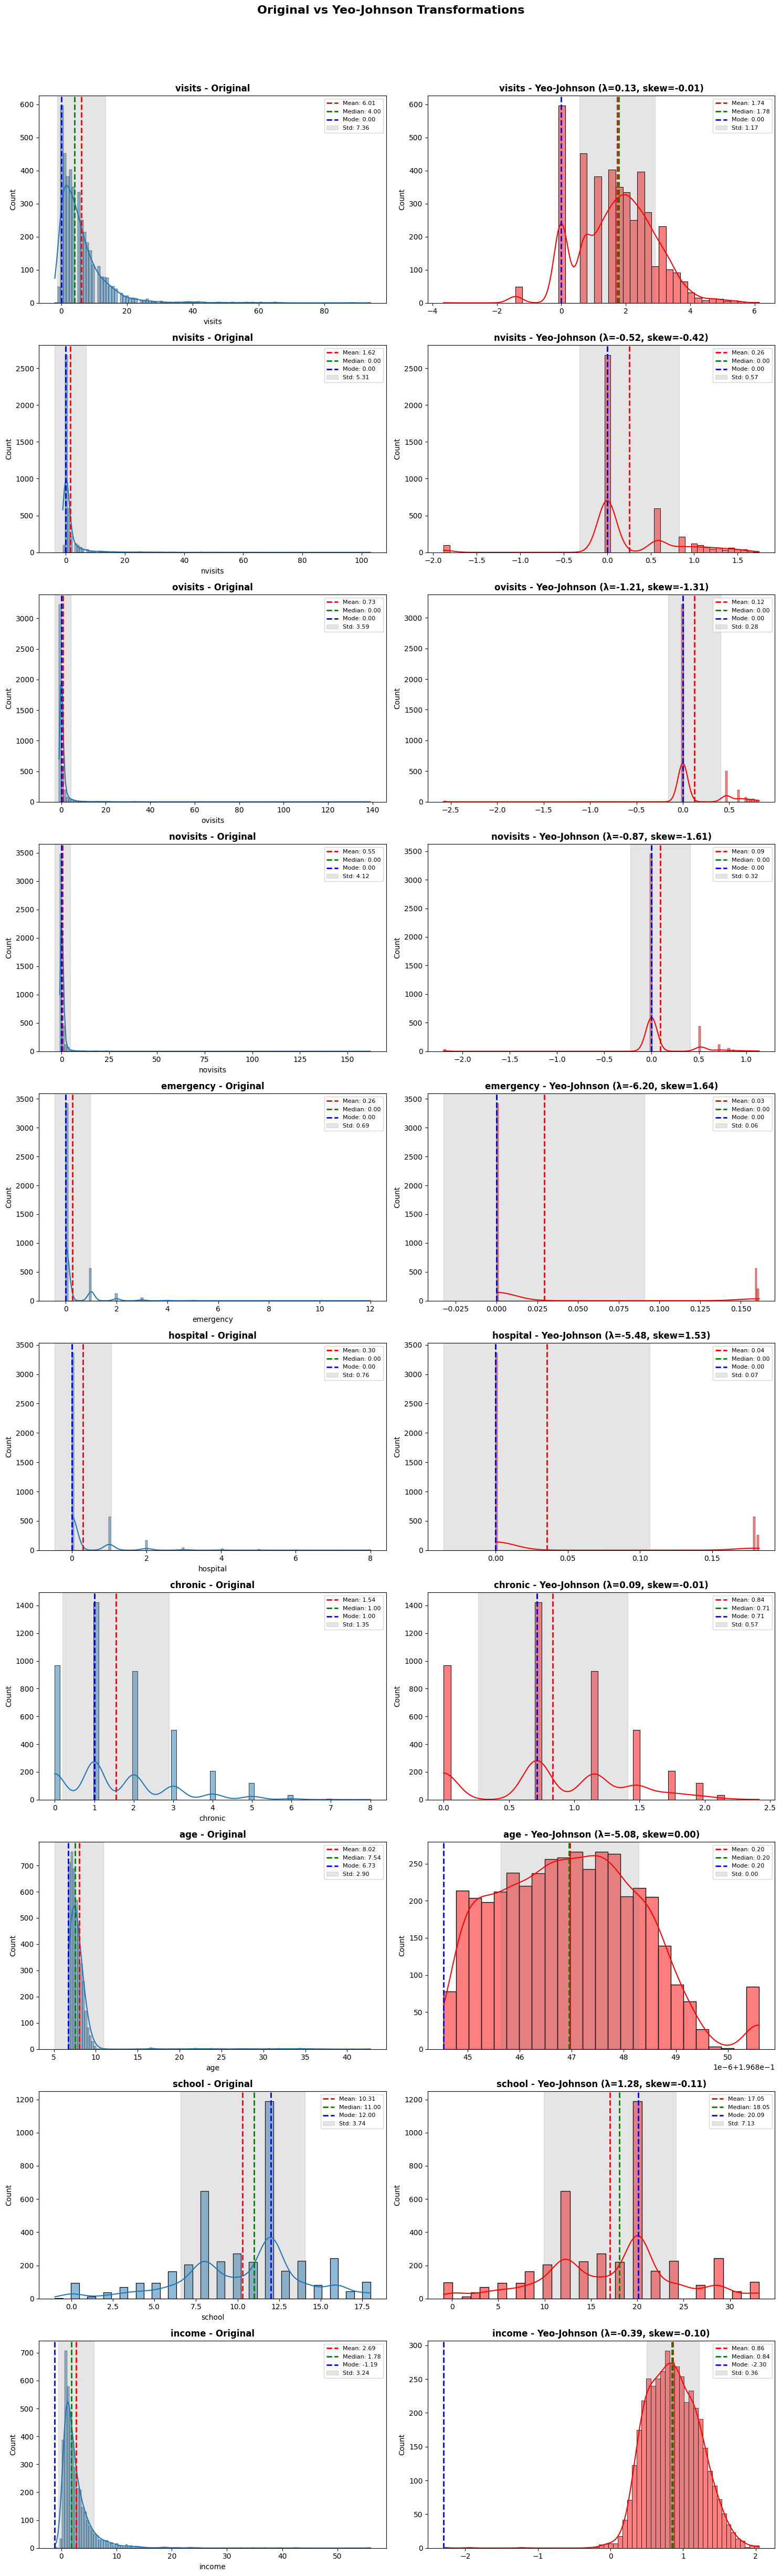

In [382]:
#
# Plot original and  Yeo-Johnson transformation to all the numeric columns
#


n_rows = len(numeric_cols)

fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(15, 5 * n_rows))
axes = axes.flatten()

plt.suptitle('Original vs Yeo-Johnson Transformations', fontweight='bold', fontsize=16)

# Iterate over each numeric column
plot_idx = 0
for col in numeric_cols:
    # Original data
    original = df_NSME1988_dirty[col].dropna()
    
    # ORIGINAL PLOT
    sns.histplot(data=df_NSME1988_dirty, x=col, ax=axes[plot_idx], kde=True)    
    axes[plot_idx].set_title(f'{col} - Original', fontweight='bold')

    # Calculate statistics for original
    mean_val = original.mean()
    median_val = original.median()
    mode_val = original.mode()[0] if not original.mode().empty else None
    std_val = original.std()

    # Plot Statistics as Vertical Lines
    axes[plot_idx].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    axes[plot_idx].axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')
    if mode_val is not None:
        axes[plot_idx].axvline(mode_val, color='blue', linestyle='--', linewidth=2, label=f'Mode: {mode_val:.2f}')
    
    # Add std as shaded region around mean
    axes[plot_idx].axvspan(mean_val - std_val, mean_val + std_val, alpha=0.2, color='gray', label=f'Std: {std_val:.2f}')
    axes[plot_idx].legend(fontsize=8, loc='upper right')
    
    plot_idx += 1
    
    # YEO-JOHNSON TRANSFORMED PLOT
    yeojohnson_data, yj_lambda = yeojohnson(original)
    yj_series = pd.Series(yeojohnson_data)
    
    sns.histplot(yj_series, ax=axes[plot_idx], kde=True, color='red')
    axes[plot_idx].set_title(f'{col} - Yeo-Johnson (λ={yj_lambda:.2f}, skew={yj_series.skew():.2f})', fontweight='bold')
    
    # Calculate statistics for transformed
    mean_yj = yj_series.mean()
    median_yj = yj_series.median()
    mode_yj = yj_series.mode()[0] if not yj_series.mode().empty else None
    std_yj = yj_series.std()
    
    # Plot Statistics as Vertical Lines
    axes[plot_idx].axvline(mean_yj, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_yj:.2f}')
    axes[plot_idx].axvline(median_yj, color='green', linestyle='--', linewidth=2, label=f'Median: {median_yj:.2f}')
    if mode_yj is not None:
        axes[plot_idx].axvline(mode_yj, color='blue', linestyle='--', linewidth=2, label=f'Mode: {mode_yj:.2f}')
    
    # Add std as shaded region around mean
    axes[plot_idx].axvspan(mean_yj - std_yj, mean_yj + std_yj, alpha=0.2, color='gray', label=f'Std: {std_yj:.2f}')
    axes[plot_idx].legend(fontsize=8, loc='upper right')
    
    plot_idx += 1

# Hide any unused subplots
for idx in range(plot_idx, len(axes)):
    axes[idx].set_visible(False)

# Make plots more readable and add space
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [383]:
# 
# grubbs_test for transformed data
#
def run_grubbs_test_for_transformed_data():

    # Run Grubbs test on transformed data
    for col in numeric_cols:
        print(f"\n{'='*60}")
        print(f"Column: {col}")
        print(f"{'='*60}")
        
        # Get original data
        original = df_NSME1988_dirty[col].dropna()
        
        # Apply Yeo-Johnson transformation
        yeojohnson_data, yj_lambda = yeojohnson(original)
        yj_series = pd.Series(yeojohnson_data)
        
        # Check if transformation improved normality
        orig_skew = original.skew()
        yj_skew = yj_series.skew()
        
        print(f"Original skewness: {orig_skew:.2f}")
        print(f"Transformed skewness: {yj_skew:.2f}")
        print(f"Lambda: {yj_lambda:.2f}")
        
        # Run Grubbs test on transformed data
        if abs(yj_skew) < 1:  # Reasonably normal
            G, p_val = grubbs_test(yj_series)
            print(f"\nGrubbs Test Results:")
            print(f"  G-statistic: {G:.4f}")
            print(f"  P-value: {p_val:.4f}")
            
            if p_val < 0.05:
                print(f"  ✓ Significant outlier detected (p < 0.05)")
            else:
                print(f"  ✗ No significant outlier detected (p ≥ 0.05)")
        else:
            print(f"\n⚠ Still too skewed (|{yj_skew:.2f}| >= 1) for reliable parametric test")


#
# Rerun Initial grubbs_test
#

run_grubbs_test_for_transformed_data()


Column: visits
Original skewness: 3.61
Transformed skewness: -0.01
Lambda: 0.13

Grubbs Test Results:
  G-statistic: 4.6050
  P-value: 0.0000
  ✓ Significant outlier detected (p < 0.05)

Column: nvisits
Original skewness: 7.54
Transformed skewness: -0.42
Lambda: -0.52

Grubbs Test Results:
  G-statistic: 3.7305
  P-value: 0.0002
  ✓ Significant outlier detected (p < 0.05)

Column: ovisits
Original skewness: 19.56
Transformed skewness: -1.31
Lambda: -1.21

⚠ Still too skewed (|-1.31| >= 1) for reliable parametric test

Column: novisits
Original skewness: 23.65
Transformed skewness: -1.61
Lambda: -0.87

⚠ Still too skewed (|-1.61| >= 1) for reliable parametric test

Column: emergency
Original skewness: 5.04
Transformed skewness: 1.64
Lambda: -6.20

⚠ Still too skewed (|1.64| >= 1) for reliable parametric test

Column: hospital
Original skewness: 3.97
Transformed skewness: 1.53
Lambda: -5.48

⚠ Still too skewed (|1.53| >= 1) for reliable parametric test

Column: chronic
Original skewness

# 2. Wrangle The Data #

### Clean Up Missing Data Issues ###
    In our case we've previously identified that the columns with missing data are of type float.
    We want to determine which data replacement strategy works best with our data.
    We have the following replacement techniques available to us:
- **Mean imputation**: Replace missing values with the column mean
- **Median imputation**: Replace missing values with the column median
- **KNN imputation**: Use K-Nearest Neighbors to estimate missing values
- **Iterative imputation**: Model each feature as a function of others (MICE algorithm)

## ##
    What we really want to do is apply the different techniques and then determine which one works best for our needs.
    We could do this 2 ways:
- **Apply the same method for the desired columns** </br>
(Simpler/Faster)
- **Iterate through the columns one by one to determine what is best for each column** </br>
(More Precise, but doesn't make sense for all strategies - KNN/Mice use other columns)

## ##
    For expiedency and simplification purposes, we will use the same missing data replacement technique across columns.

    To find the best technique, we must test against known data. 
    To that end, we'll create a sample data set void of rows with missing data.
    We'll make a copy of that data set (A). Next we'll making a second data set A and randomly
    create missing values across the columsn of interest.
    Then we will run our selected replacement strategies capturing the results (with missing data replaced).
    We then compare our original sample (A) against the modified samples and determine which technique works best.


##### Filter out existing rows with missing data - create dataset copy with manufactured missing rows#####

In [ ]:
#
# Count the number of "complete/clean" rows of data and number of rows that have missing data
#

columns_with_missing_data = ['visits','nvisits','ovisits','novisits','emergency',
                            'hospital','chronic','age','school','income','insurance']
complete_rows = df_NSME1988_dirty[columns_with_missing_data].dropna()
rows_with_missing_data = df_NSME1988_dirty[df_NSME1988_dirty[columns_with_missing_data].isnull().any(axis=1)]

print(f"Complete rows: {len(complete_rows)}")
print(f"Rows with missing data: {len(rows_with_missing_data)}")



Complete rows: 2563
Rows with missing data: 1843


### Data Type conversion ###

In [385]:
# Int64 to Int16 conversions
columns = ['visits', 'nvisits', 'ovisits', 'novisits', 'emergency', 'hospital', 
            'chronic', 'school']

df_NSME1988_dirty_new[columns] = df_NSME1988_dirty[columns].astype('int16')


# Mulitply Age by 10 to get true age in years, convert to int
df_NSME1988_dirty_new['age'] = df_NSME1988_dirty['age'] * 10
df_NSME1988_dirty_new['age'] = df_NSME1988_dirty_new['age'].astype('int16')

# Mulitply Income by 1000 to get true value and convert to int
df_NSME1988_dirty_new['income'] = df_NSME1988_dirty['income'] * 1000
df_NSME1988_dirty_new['income'] = df_NSME1988_dirty_new['income'].astype('int32')


print()
print("Dataframe with modified data types:")
df_NSME1988_dirty_new.info()
print()
print()

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

#### Feature Distributions for Categorical Columns ####

Categorical (String) Feature Columns to plot
['health', 'adl', 'region', 'gender', 'married', 'employed', 'insurance', 'medicaid']
Number of Columns: 8


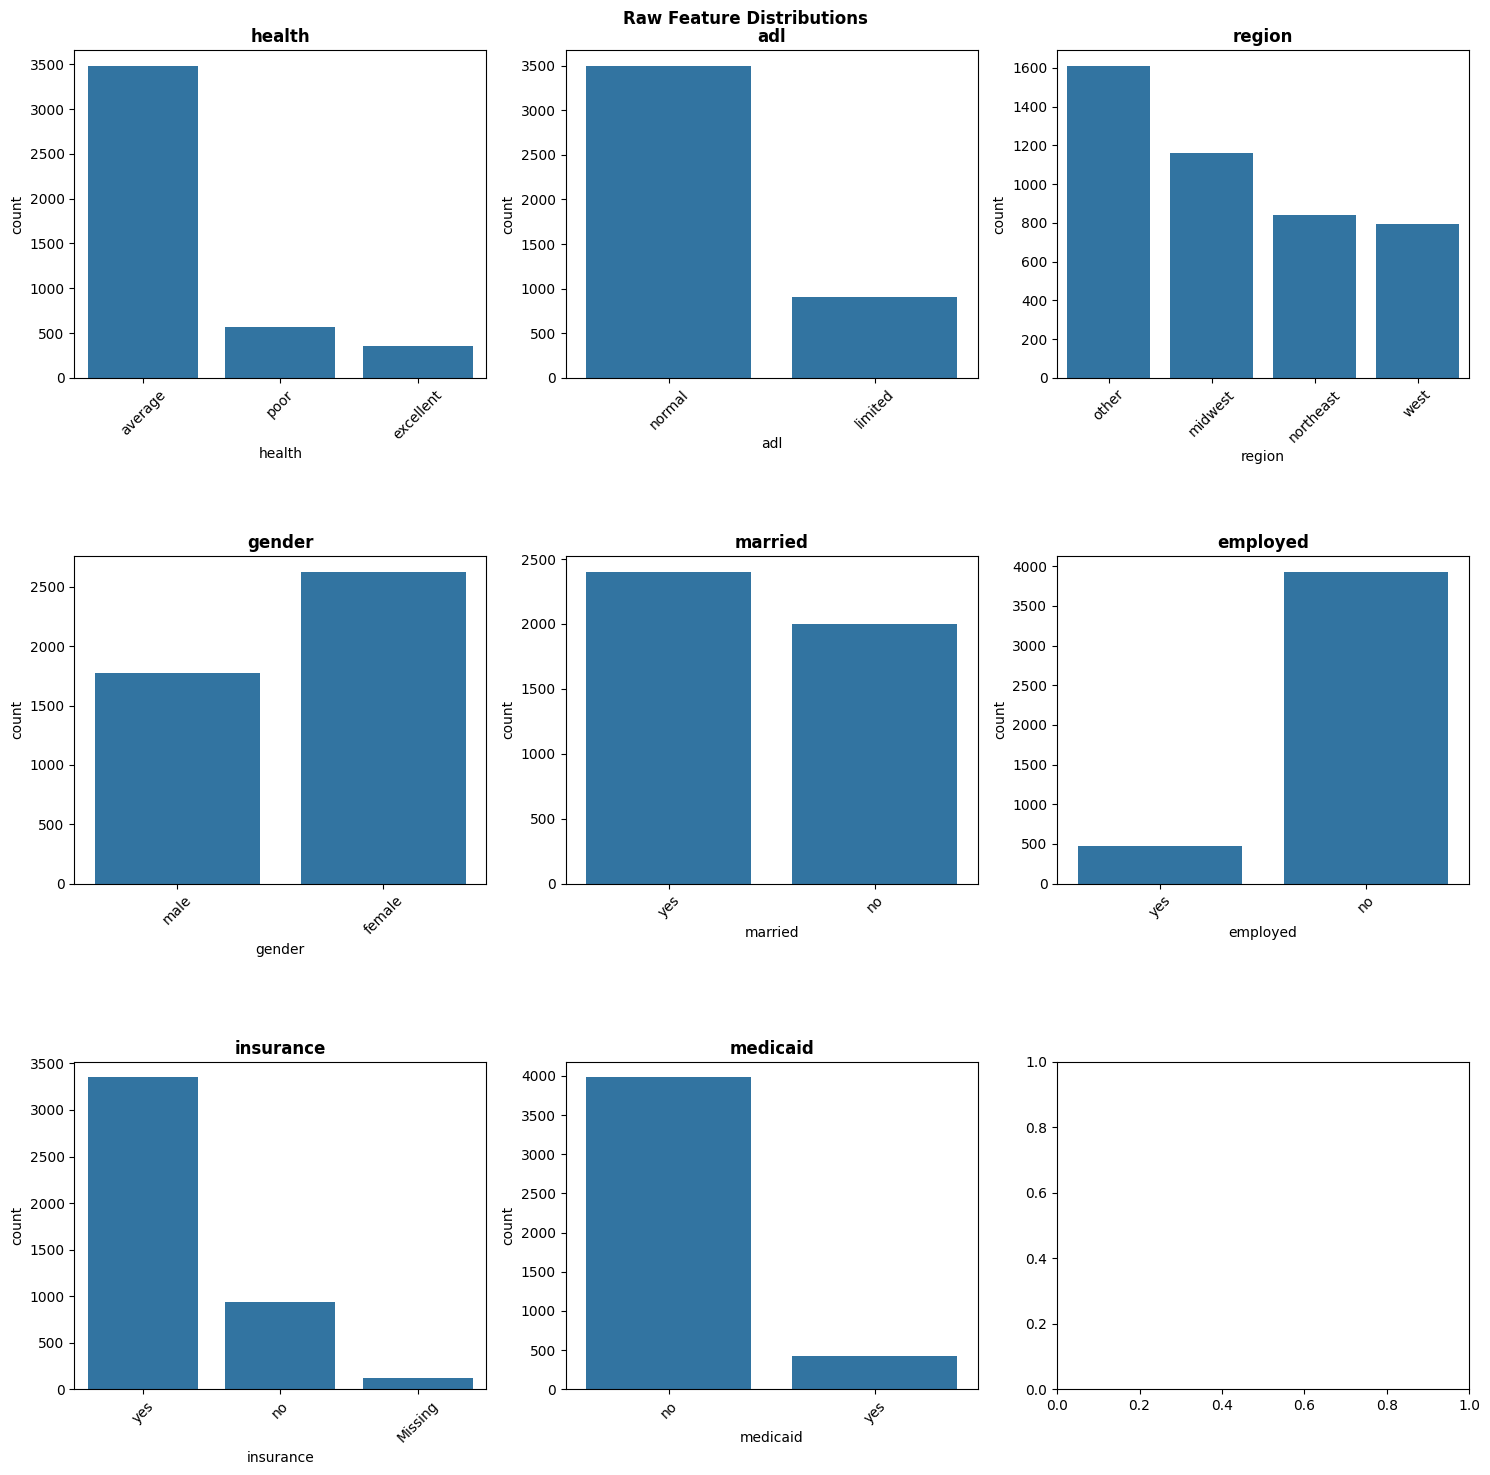

In [ ]:
# The columns we want to plot:
print('Categorical (String) Feature Columns to plot')
object_cols = df_NSME1988_dirty.select_dtypes(include=['object']).columns.tolist()
print(object_cols)

n_cols = len(object_cols)
print(f'Number of Columns: {n_cols}')

fig, axes = plt.subplots(nrows=(n_cols + 2) // 3, ncols=3, figsize=(15, 5 * ((n_cols + 2) // 3)))
axes = axes.flatten()

plt.suptitle('Raw Feature Distributions', fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.90])  # Leave space at top

#Iterate over each numeric column and plot a historgram
for i, col in enumerate(object_cols):
    temp_data = df_NSME1988_dirty[col].fillna('Missing')
    sns.countplot(x=temp_data, ax=axes[i])  # Use x= instead of data=
    axes[i].set_title(col, fontweight='bold')
    axes[i].tick_params(axis='x', rotation=45)

# Make plots more readable and add space
plt.tight_layout(h_pad=5)
plt.show()  

#### Analysis of Plotted Raw Data ####
    Categorical Data
        - Replacement of "Nan" and plotting visually reveals missing data for:
            insurance

##### Analyzing Number of Visits #####

In [ ]:
import matplotlib.scale as mscale

number_of_visit_columns = ['physician_office_visits' ,
                            'nonphysician_office_visits' ,
                            'physician_outpatient_visits' ,
                            'nonphysician_outpatient_visits' ,
                            'emergency_room_visits' ,
                            'number_of_hospital_stays']

n_cols = len(number_of_visit_columns) * 2 + 4
print(f'Number of Columns: {n_cols}')

print('Min - Max - Mode Visits')
for i, col in enumerate(number_of_visit_columns):
    print(f'{col} Min Visits: {df_NSME1988_new[col].min()} Max Visits: {df_NSME1988_new[col].max()} Mode Visits: {df_NSME1988_new[col].mode()}')
print()
print()

print('Min - Max - Mode Visits - Excluding zero and outliers')
for i, col in enumerate(number_of_visit_columns):
    data_gt_zero = df_NSME1988_new[df_NSME1988_new[col] > 0][col]
    print(f'{col} Min Visits: {data_gt_zero.min()} Max Visits: {data_gt_zero.max()} Mode Visits: {data_gt_zero.mode()}')
print()
print()

# I need a 4X4 plot to display 10 histograms
fig, axes = plt.subplots(nrows=(n_cols + 2) // 3, ncols=3, figsize=(15, 5 * ((n_cols + 2) // 3)))
axes = axes.flatten()

# Iterate over each numeric column and plot a historbram
for i, col in enumerate(number_of_visit_columns):
    
    # Initially plots looked weird because of outliers (bad data) and produced less than meaningful results
    # Set x-axis limit to 95th percentile to exclude extreme outliers
    # This only works on visits/number of columns

    max_val = df_NSME1988_new[col].max()
    binwidth = max(1, max_val // 20)  # Divide range into ~20 bins
    sns.histplot(data=df_NSME1988_new, x=col, ax=axes[i], binwidth=binwidth, kde=True)
    axes[i].set_xlim(left=0)
   
    # tried different scaling techniques and results are still weird
    #axes[i].set_yscale('function', functions=(lambda x: x**0.5, lambda x: x**2))
    #axes[i].set_yscale('log')
    # trying binning (above) next; finally binwidt

    axes[i].set_title(f'{col} Including Zero(0) Visits')

# Excluding zeros
for i, col in enumerate(number_of_visit_columns):
    
    # Initially plots looked weird because of outliers (bad data) and produced less than meaningful results
    # Set x-axis limit to 95th percentile to exclude extreme outliers
    # This only works on visits/number of columns
    
    # Filter out zeros
    data_no_zeros = df_NSME1988_new[df_NSME1988_new[col] > 0][col]
    
    max_val = data_no_zeros.max()
    bins = np.arange(0.5, max_val + 1.5, 1)
    
    j = i + 6
    axes[j].hist(data_no_zeros, bins=bins, edgecolor='black')
    axes[j].set_xlabel('Number of Visits')
    axes[j].set_ylabel('Count')

    axes[j].set_title(f'{col} Excluding Zero(0) Visits')    

    
# Hide the blank/empty graphs
for j in range(j + 1, len(axes)):
    axes[j].set_visible(False)

# Make plots more readable and add space
plt.tight_layout(h_pad=5)
plt.show()    
print("Completed")

Number of Columns: 16
Min - Max - Mode Visits


NameError: name 'df_NSME1988_new' is not defined

##### Number of Visits Analysis ####
    All the plots have a strong right (positive) skewed shape
    In most cases zero (0) is the highest number of visits.
    There were also several (negative) outliers which indicates bad data (you can't have -99 visits..)
    I tried to get around this be set the ylimit to account for these.
    I tried different scales/binning techniques to make the plots more readable/interpretable

    Central Mean Tendency - including zero visits

        physician_office_visits Min Visits: 0 Max Visits: 89 Mode Visits: 0    
        nonphysician_office_visits Min Visits: 0 Max Visits: 104 Mode Visits: 0    
        physician_outpatient_visits Min Visits: -115 Max Visits: 71 Mode Visits: 0    
        nonphysician_outpatient_visits Min Visits: -101 Max Visits: 113 Mode Visits: 0    
        emergency_room_visits Min Visits: 0 Max Visits: 12 Mode Visits: 0    
        number_of_hospital_stays Min Visits: 0 Max Visits: 8 Mode Visits: 0    

    Central Mean Tendency - excluding zero visits
    (I thought it would be interesting examine these values excluding values <=0 - Excluding 0 and negative outliers)
        physician_office_visits Min Visits: 1 Max Visits: 89 Mode Visits: 1
        nonphysician_office_visits Min Visits: 1 Max Visits: 104 Mode Visits: 1
        physician_outpatient_visits Min Visits: 1 Max Visits: 71 Mode Visits: 1
        nonphysician_outpatient_visits Min Visits: 1 Max Visits: 113 Mode Visits: 1
        emergency_room_visits Min Visits: 1 Max Visits: 12 Mode Visits: 1
        number_of_hospital_stays Min Visits: 1 Max Visits: 8 Mode Visits: 1

    Based on this, clearly the lower occurring number of visits are dominant in this data set.
    As the number if visits increases, number of instances of visits decreases (inverse relationship)

##### Additional Analysis #####

Number of Columns: 8


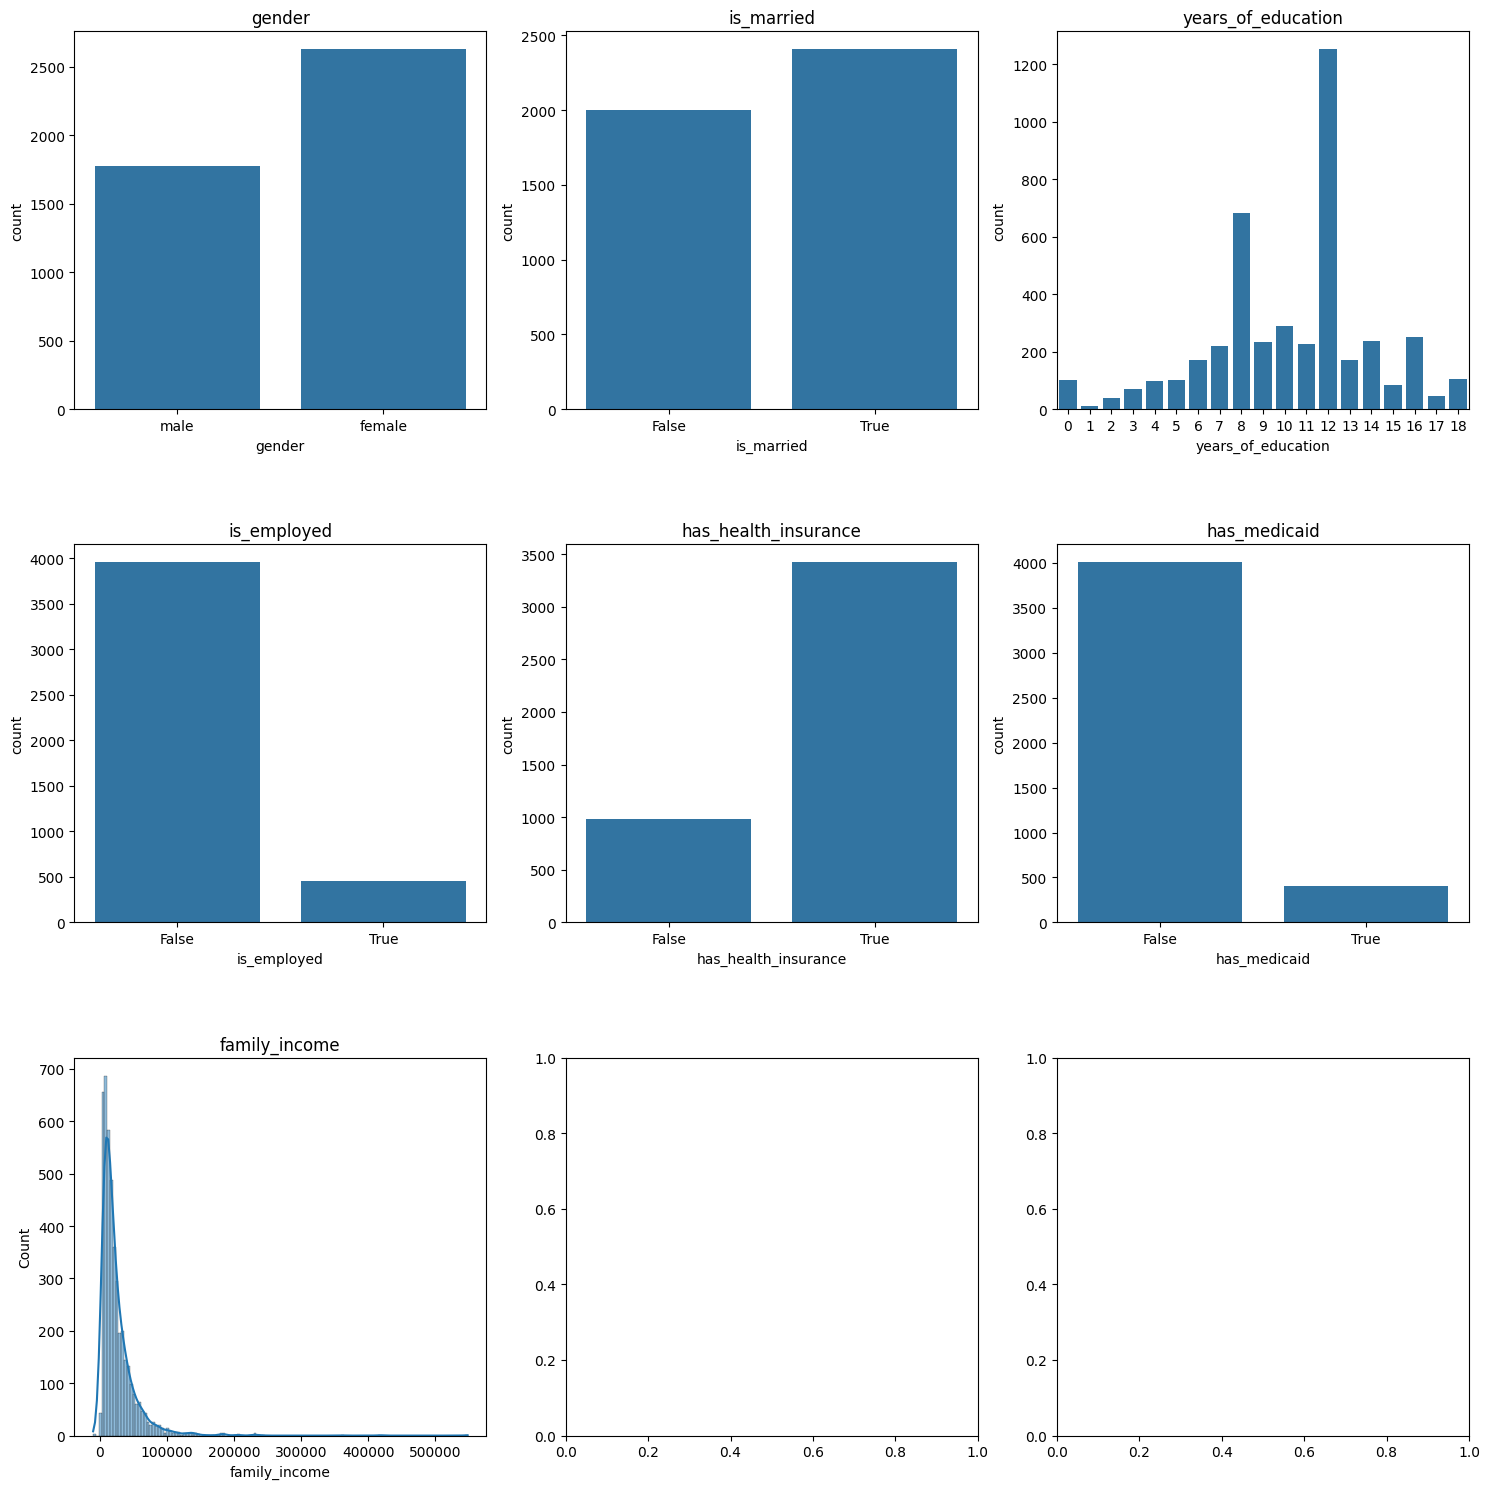

In [ ]:
# The columns we want to plot:
columns_to_plot = [ 'gender' ,
                    'is_married' ,
                    'years_of_education' ,
                    'is_employed' ,
                    'has_health_insurance' ,
                    'has_medicaid']

n_cols = len(columns_to_plot) + 2
print(f'Number of Columns: {n_cols}')

# I need a 4X4 plot to display 10 histograms
fig, axes = plt.subplots(nrows=(n_cols + 2) // 3, ncols=3, figsize=(15, 5 * ((n_cols + 2) // 3)))
axes = axes.flatten()

#sns.countplot(data=df_NSME1988_new, x='gender', ax=axes[0])

#Iterate over each numeric column and plot a historgram
for i, col in enumerate(columns_to_plot):
    
    sns.countplot(data=df_NSME1988_new, x=col, ax=axes[i])
    axes[i].set_title(col)

i+=1
sns.histplot(data=df_NSME1988_new, x='family_income', ax=axes[i], kde=True)    
axes[i].set_title('family_income')

# Make plots more readable and add space
plt.tight_layout(h_pad=5)
plt.show()    

In [ ]:
print('Min - Max - Mode Visits')
col = 'years_of_education'
print(f'{col} Min: {df_NSME1988_new[col].min()} Max: {df_NSME1988_new[col].max()} Mode: {df_NSME1988_new[col].mode()}')
col = 'family_income'
print(f'{col} Min: {df_NSME1988_new[col].min()} Max: {df_NSME1988_new[col].max()} Mode: {df_NSME1988_new[col].mode()}')
print()
print()

Min - Max - Mode Visits
years_of_education Min: 0 Max: 18 Mode: 0    12
Name: years_of_education, dtype: int8
family_income Min: -10125 Max: 548351 Mode: 0    4320
Name: family_income, dtype: int64




##### Analysis of remaining requested columns ####
    Gender - relatively balanced distribution, more women than men
    Married - relatively balanced distribution, more yes than no
    Years of Education - hard to read based on plot. Looks like it almost wants to be normal distibution but kind of looks right skewed
    Employed - There seems to be a lot more unemployed than employed people in this data set (by a large margin 40 - 5 ratio)
    Has Health Insurance - Most people have health insurance by a large margin (~3.5X as many people have health insurance than not)
    Had Medicaid - Most people have do not have medicaid by a large margin (~8X as many people do not have medicaid)
    Family Income - Definite right (positive) skew to the data


    Central Mean Tendency: 
        years_of_education Min: 0 Max: 18 Mode: 12
        family_income Min: -10125 Max: 548351 Mode: 4320

    Family income definitely has outlier (bad) data with substantial negative income
    

    

##### Distribution of Patient Visit Types - occurances of each type #####

{'physician_office_visits': np.int64(25442), 'nonphysician_office_visits': np.int64(7129), 'physician_outpatient_visits': np.int64(3052), 'nonphysician_outpatient_visits': np.int64(2106), 'emergency_room_visits': np.int64(1161), 'number_of_hospital_stays': np.int64(1304)}


C:\Users\jxbma\AppData\Local\Temp\ipykernel_37412\3893749027.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(total_visits.keys()), y=list(total_visits.values()), palette='viridis')


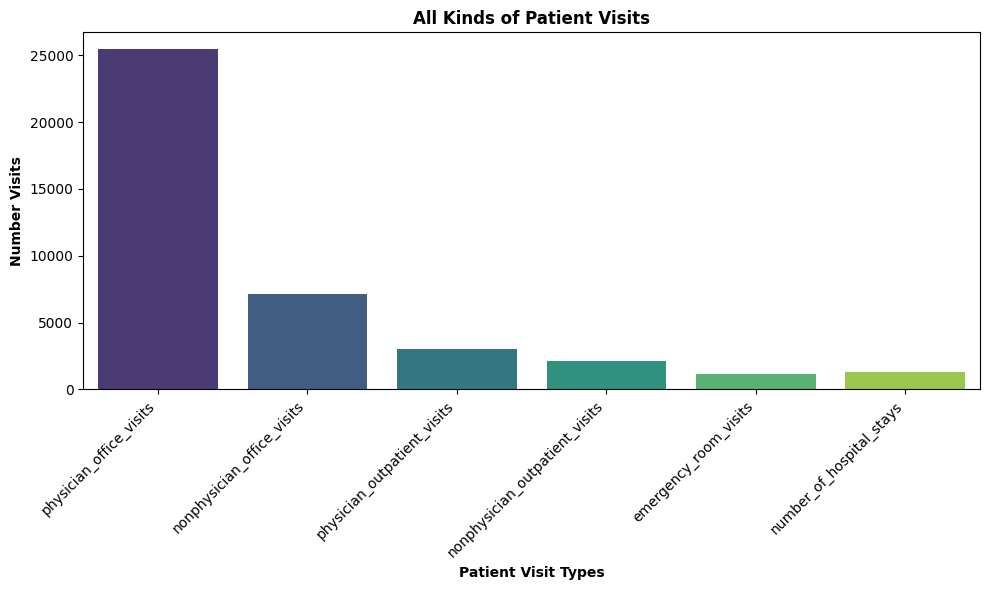

In [ ]:
total_visits = { 'physician_office_visits' : df_NSME1988_new['physician_office_visits'].sum(),
                 'nonphysician_office_visits' : df_NSME1988_new['nonphysician_office_visits'].sum(),
                 'physician_outpatient_visits' : df_NSME1988_new['physician_outpatient_visits'].sum(),
                 'nonphysician_outpatient_visits' : df_NSME1988_new['nonphysician_outpatient_visits'].sum(),
                 'emergency_room_visits': df_NSME1988_new['emergency_room_visits'].sum(),
                 'number_of_hospital_stays' : df_NSME1988_new['number_of_hospital_stays'].sum()}

print(total_visits)

plt.subplots(figsize=(10, 6))


# Title and Label axes
plt.title(f'All Kinds of Patient Visits', fontweight='bold')
plt.xlabel('Patient Visit Types', fontweight='bold')
plt.ylabel('Number Visits', fontweight='bold')
plt.xticks(rotation=45, ha='right')

sns.barplot(x=list(total_visits.keys()), y=list(total_visits.values()), palette='viridis')

plt.tight_layout(h_pad=3)
plt.show()

##### Analysis of different patient visits ####
    I wanted to take a look at the different kinds of medical visits and see if I could spot any trends.
    The highest number of visits is for Physician Office Visits. After that numbers fall off dramatically.
    The next higest is Nonphysician office visits. As we progress through the other types of medical visits,
    there is a much tighter range in the counts. The differences between the visit types become much smaller.
    The smallest number of actual provider visits is Emergency Room Visits. I added Hospital Visits so I 
    could see what those numbers look like. In totality, the smallest number of overall "medical visits" is
    Hospital Stays, which is kind of expected.
    

    

#### Create Crosstabs for Requested Distributions ####

age_group: age_group
66-70    1568
71-75    1266
76-80     846
81-85     479
86+       247
Name: count, dtype: int64

gender: gender
female    2628
male      1778
Name: count, dtype: int64
overall_health_factor: overall_health_factor
average      3509
poor          554
excellent     343
Name: count, dtype: int64

gender: gender
female    2628
male      1778
Name: count, dtype: int64
income_category: income_category
10-25k     1682
<10k       1229
25-50k      973
50-100k     406
100k+        95
Name: count, dtype: int64

gender: gender
female    2628
male      1778
Name: count, dtype: int64
region: region
other        1614
midwest      1157
northeast     837
west          798
Name: count, dtype: int64

income_category: income_category
10-25k     1682
<10k       1229
25-50k      973
50-100k     406
100k+        95
Name: count, dtype: int64
age_group: age_group
66-70    1568
71-75    1266
76-80     846
81-85     479
86+       247
Name: count, dtype: int64

income_category: income_category

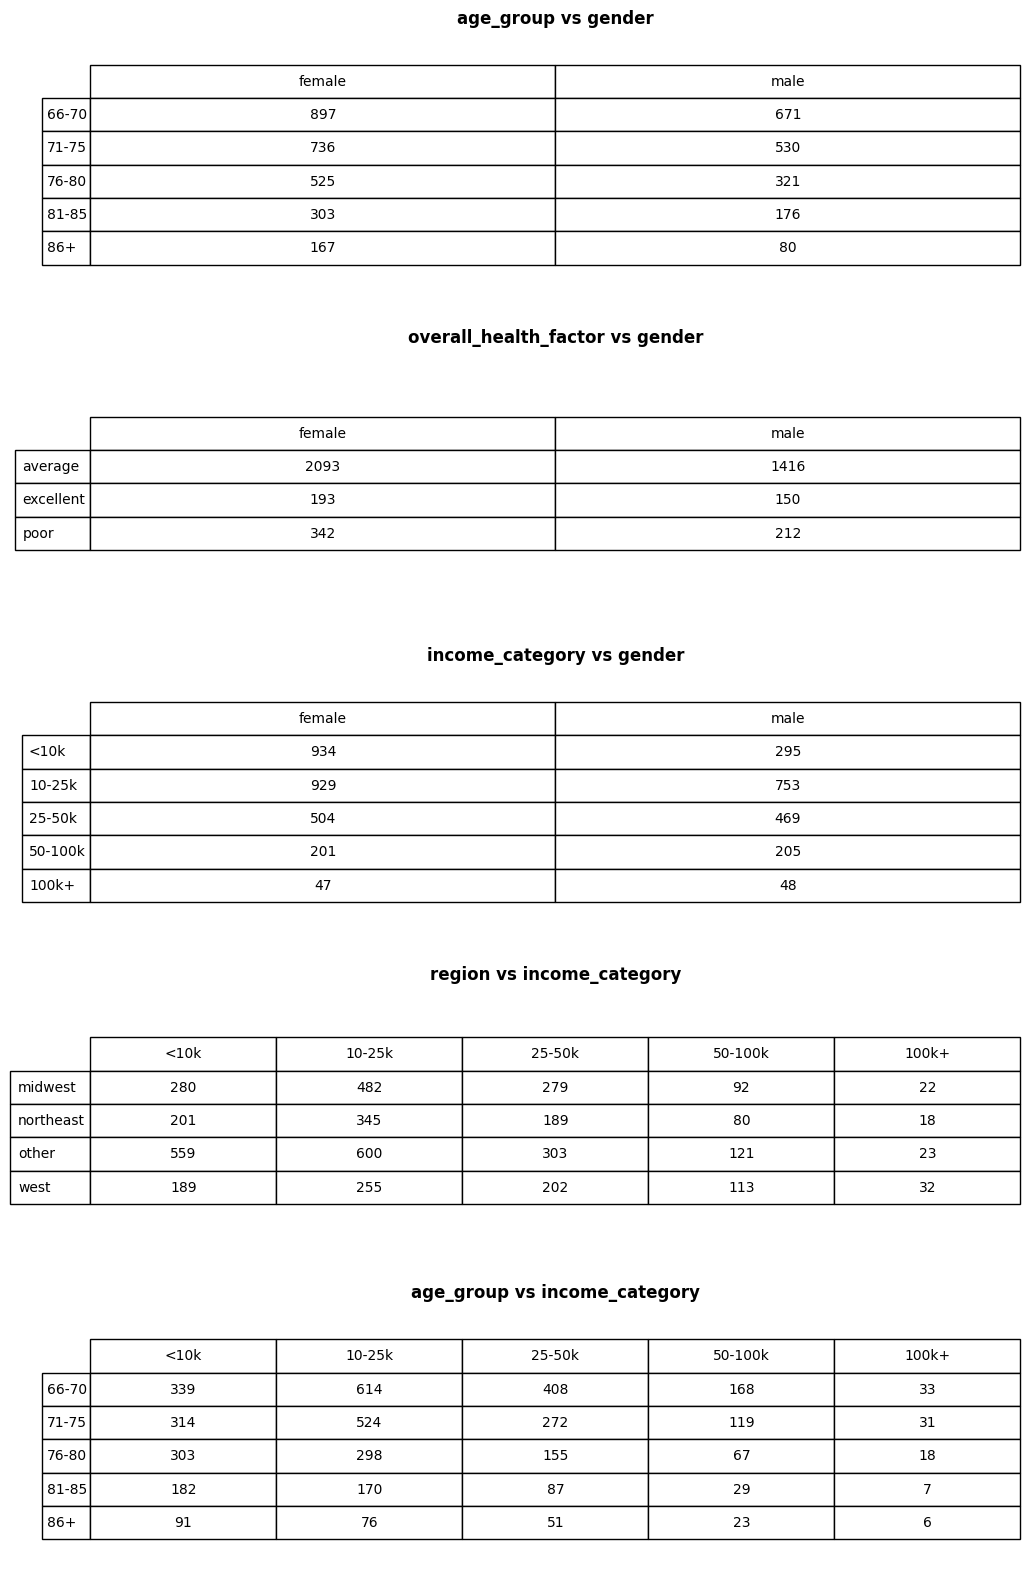

In [ ]:

# Performance was horrible with family_income, trying to bin it instead
# Create income categories instead of raw values
# Bin Ages as well for cleaner display
df_NSME1988_new['income_category'] = pd.cut(
    df_NSME1988_new['family_income'], 
    bins=[0, 10000, 25000, 50000, 100000, 1000000],
    labels=['<10k', '10-25k', '25-50k', '50-100k', '100k+']
)

df_NSME1988_new['age_group'] = pd.cut(
    df_NSME1988_new['age'],
    bins=[65, 70, 75, 80, 85, 120],
    labels=['66-70', '71-75', '76-80', '81-85', '86+']
)

# Distributions
features = [ 
    ('age_group', 'gender'),
    ('overall_health_factor', 'gender'),
    ('income_category', 'gender'),
    ('region', 'income_category'),
    ('age_group', 'income_category')
]
features_with_crosstabs = []

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 20))
axes = axes.flatten()
i = 0

for feature1, feature2 in features:

    feature1_counts = df_NSME1988_new[feature1].value_counts()
    feature2_counts = df_NSME1988_new[feature2].value_counts()
    print(f'{feature1}: {feature1_counts}')
    print()
    print(f'{feature2}: {feature2_counts}')

    # Create crosstab
    ct = pd.crosstab(df_NSME1988_new[feature1], df_NSME1988_new[feature2])
    features_with_crosstabs.append((feature1, feature2, ct))

    axes[i].axis('tight')
    axes[i].axis('off')

    # Create table
    table = axes[i].table(cellText=ct.values, 
                          rowLabels=ct.index, 
                          colLabels=ct.columns,
                          cellLoc='center',
                          loc='center')

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)  # Adjust cell height

    axes[i].set_title(f'{feature1} vs {feature2}', fontsize=12, fontweight='bold')
    i +=1


plt.show()

#### Heat Maps (plots) of Requested Distributions ####

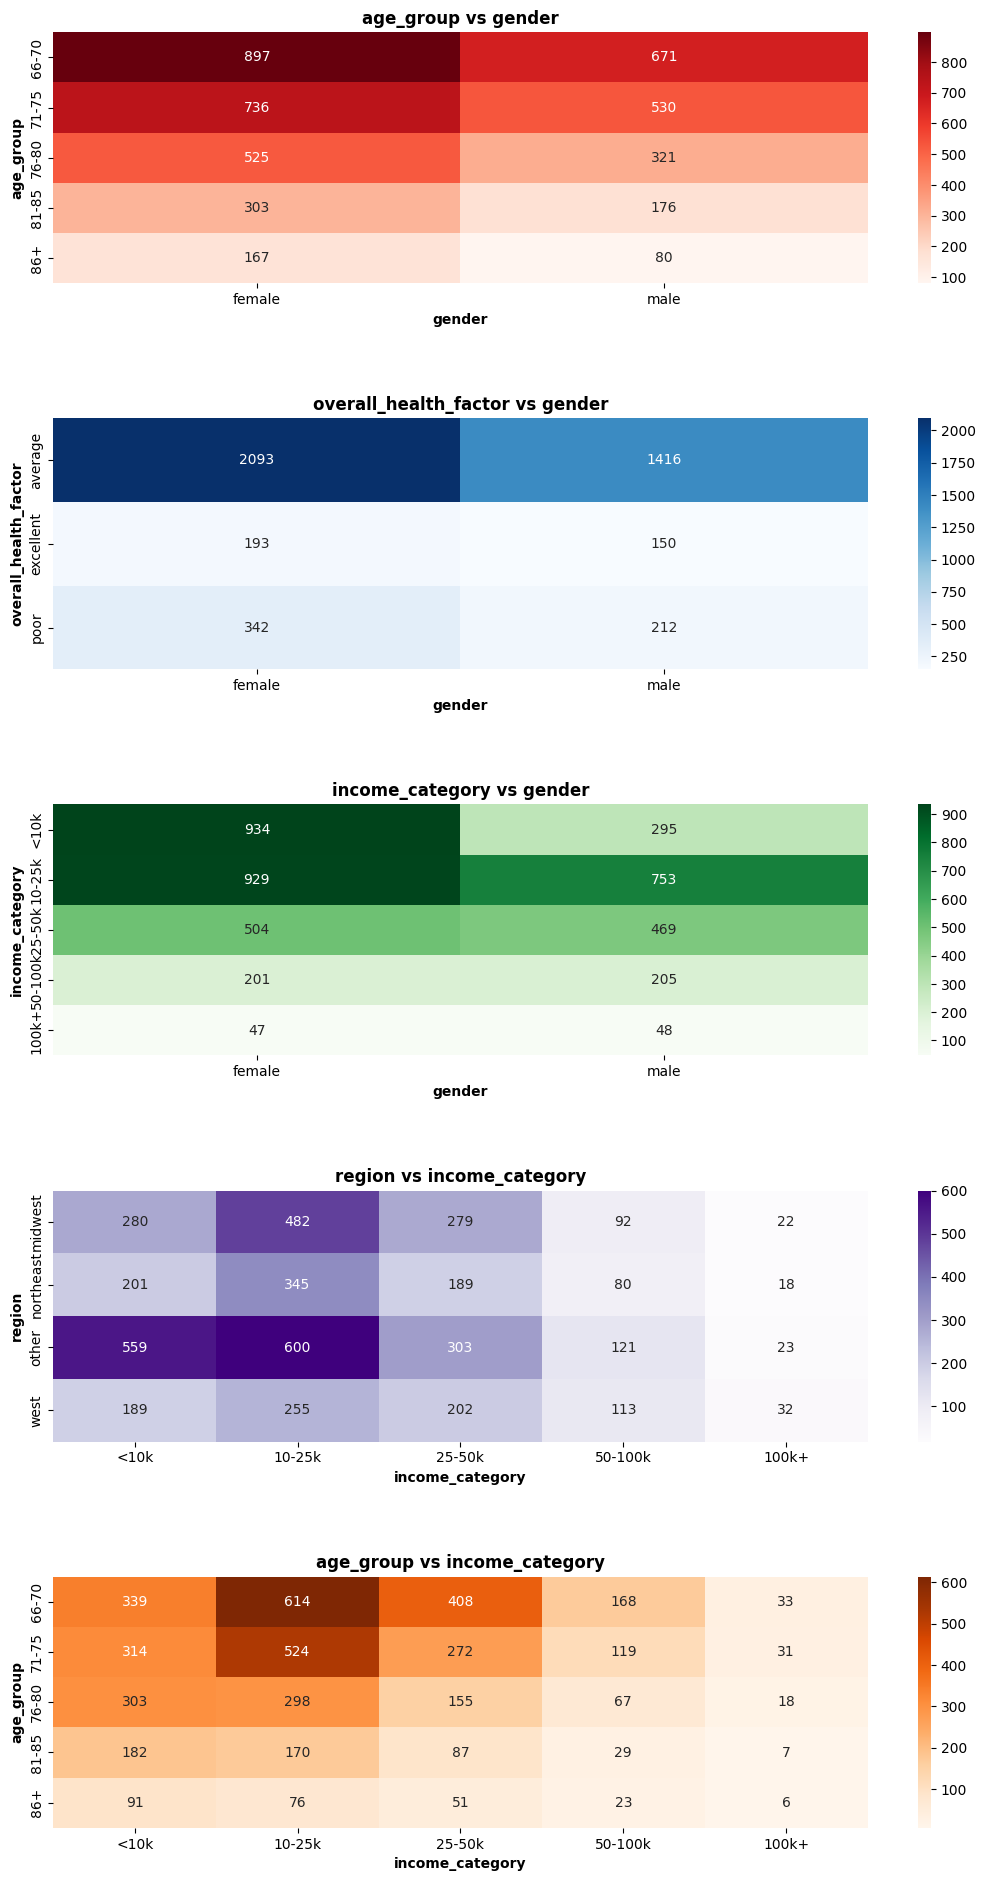

In [ ]:

colors = ['Reds', 'Blues', 'Greens', 'Purples', 'Oranges']
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 20))
axes = axes.flatten()
i = 0

for feature1, feature2, ct in features_with_crosstabs:

    sns.heatmap(ct, annot=True, fmt='d', cmap=colors[i], ax=axes[i])

    # Title and Label axes
    axes[i].set_title(f'{feature1} vs {feature2}', fontweight='bold')
    axes[i].set_xlabel(f'{feature2}', fontweight='bold')
    axes[i].set_ylabel(f'{feature1}', fontweight='bold')

    i += 1

plt.tight_layout(pad=5) 
plt.show()

### Averages Calculations ###

In [ ]:
print('Average Salaries of Men and Women')

avg_income_by_gender = df_NSME1988_new.groupby('gender')['family_income'].mean()

for gender, avg in avg_income_by_gender.items():
    print(f"{gender.capitalize()}: ${avg:,.2f}")

# Calculate the gap
female_avg = avg_income_by_gender['female']
male_avg = avg_income_by_gender['male']

print(f"\nIncome gap: ${male_avg - female_avg:,.2f}")
print(f"Male income is {(male_avg/female_avg - 1)*100:.1f}% higher")
print()
print('--------------------------------------------------------------------')
print()

print('Average Salaries Across Regions')

avg_income_by_region = df_NSME1988_new.groupby('region')['family_income'].mean()

for region, avg in avg_income_by_region.items():
    print(f'"{region}": "${avg:,.2f}"')

print()
print('--------------------------------------------------------------------')
print()

print('Average Salaries Across Age Ranges')

avg_income_by_region = df_NSME1988_new.groupby('age_group')['family_income'].mean()

for age_group, avg in avg_income_by_region.items():
    print(f'"{age_group}": "${avg:,.2f}"')


Average Salaries of Men and Women
Female: $22,493.48
Male: $29,377.16

Income gap: $6,883.68
Male income is 30.6% higher

--------------------------------------------------------------------

Average Salaries Across Regions
"midwest": "$25,136.34"
"northeast": "$26,797.09"
"other": "$21,662.84"
"west": "$31,165.05"

--------------------------------------------------------------------

Average Salaries Across Age Ranges
"66-70": "$27,488.76"
"71-75": "$26,194.35"
"76-80": "$22,997.60"
"81-85": "$20,269.47"
"86+": "$23,951.36"


C:\Users\jxbma\AppData\Local\Temp\ipykernel_37412\1941309176.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_income_by_region = df_NSME1988_new.groupby('age_group')['family_income'].mean()


### Bivariate Analysis of Requested Feature Relationships ###
    Intially I tried running the bivariate analysis against the raw data. </br>
    I ran into several issues:</br>
        - Performance was horribly slow</br>
        - Results weren't exactly clear and difficult to read</br>
        - It was challenging to identify trends in the relationships just based on the crosstab tables</br>

    Resolutions:</br>
        - The worst offender for performance/visibility was Income. To rectify the issue, I binned the data into</br>
        categories (income ranges). This sped up performance dramatically and made the results easier to examine.</br>
        I used the same strategy with age. </br>
        - I still had issues identifying trends. Being a visual person, I plotted the bivariate feature relationships into</br>
        Heat Maps. This made the trends much easier to see at a glance. From that I was able to go back to the crosstab</br>
        tables see the exact numbers in the relationships.

##### <u>Age Group versus Gender</u> #####
    - Most people are in the 66-80 age range
    - The 86+ age group has the fewest number of people
    - The highest concentration is women between the ages of 66 and 75
    - The highest gender-age group is women in the 66-79 ag range
    - There are more women than men in the sample
    - Not sure if this is due to women living longer  (total assumption) or more women seek medical attention than men (another assumption)
    - Other factors might be involved - how were the samples collected?

##### <u>Overall Health versus Gender</u> #####
    - Based on the heatmap, you can clearly see most people across both genders (individually and combined) are in "average" health
    - The highest concetration is women in average health (2093)
    - More people (men and women) report being in poor health than in excellent health
    - Surprising to see that the second highest concentration across both genders (individually and combined) are in "poor" health
    - The trend of average (highest) - poor - excellent (lowest) is consistent across genders
    - The distribution across different categories is consistent across genders (at least roughly proportionally)
    - There are more women than men in the sample (see above)

##### <u>Income Category  versus Gender</u> #####
    - The highest concentration of income category vs gender is women making under $50k
    - Based on this sample women (relative to their gender) make less then men (the lower income ranges have a higher concentration than that of men)
    - Men and women have almost identical concentrations (in terms of pure numbers) in the $50k+ income range (gender parity)
    - Proportionally within their gender, a higher percentage of men are in the $50k+ category (relateve to women)
    - Average salary of men to women
    - There are more women than men in the sample (see above)
    - Average salaries by gender:
        Female: $22,493.48
        Male: $29,377.16
        Income gap: $6,883.68
        Male income is 30.6% higher

##### <u>Region versus Income Category</u> #####
    - Most people across all regions make < $50k
    - The highest income category across all regions is $10k - $25k
    - Fewest people earn > $100k
    - "Other" region has the highest population density across regions
    - There are more women than men in the sample (see above)
    - Average salaries by region:
        "midwest": "$25,136.34"
        "northeast": "$26,797.09"
        "other": "$21,662.84"
        "west": "$31,165.05"

##### <u>Age Group versus Income Category</u> #####
    - The highest concentration of salaries is people 66 - 80 years old making <= $50k
    - Fewest over all people (across age ranges) make >= $100k
    - Income decreases as people age (retirement/fixed incomes?)
    - Youngest age range (66-80) earns the most
    - There are more women than men in the sample (see above)
    - Average salaries by age range:
        "66-70": "$27,488.76"
        "71-75": "$26,194.35"
        "76-80": "$22,997.60"
        "81-85": "$20,269.47"
        "86+": "$23,951.36"
    

### Final Thoughts and Recap ###
    An important thing I learned is that choosing the right visualizations with the correct parameters (scaling, grouping, binning) can go
    a long way in understanding and analyzing data, trends in data and relationships between features. If you choose correctly its easier
    to visually identify patterns in the data.

    Utilizing Health Care Sevices (physician, outpatient, emergency, hospital)
    Most people did not make heavy usage of healthcare services (0 - 1 visits were by far the most common across all services)
    Physician Office visits were the most common.

    The data targeted senior populations, with disproportionate numbers of women compared to men.
    This could be due to:
        - Women living longer than men
        - Some other anamoly such women were disproportionately sampled more than men

    Most people were unemployed (retirees), had health insurance, but no medicaid.

    Income levels decrease as the population ages (due to retirement, fixed income issues or just plain lower paying, less skilled jobs)

    Found some data anamolies (outliers) in family_income and patient visits (data errors? - negative values)
    To limit the effect of the outliers, I used some filtering and scaling techniques